# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from comp411.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from comp411.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'comp411/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from comp411.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from comp411.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

grid = [(lr, reg) for lr in learning_rates for reg in regularization_strengths]

for index, (lr, reg) in enumerate(grid):

    classifier = LinearSVM()

    # create and train svm classifier
    loss = classifier.train(X_train_feats, y_train, learning_rate=lr, 
                            reg=reg, num_iters=2000, verbose=False)

    # train and val predictions
    pred_train = classifier.predict(X_train_feats)
    pred_val   = classifier.predict(X_val_feats)

    # train and val accuracy
    accuracy_train = np.mean(pred_train == y_train)
    accuracy_val   = np.mean(pred_val == y_val)

    # results
    results[(lr, reg)] = (accuracy_train, accuracy_val)

    # best val score and model
    if accuracy_val > best_val: 
        best_val = accuracy_val
        best_svm = classifier

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.103694 val accuracy: 0.124000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.101224 val accuracy: 0.111000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.414571 val accuracy: 0.412000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.118286 val accuracy: 0.126000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.411592 val accuracy: 0.418000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.402531 val accuracy: 0.397000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.416571 val accuracy: 0.417000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.406408 val accuracy: 0.409000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.316490 val accuracy: 0.308000
best validation accuracy achieved during cross-validation: 0.418000


In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.425


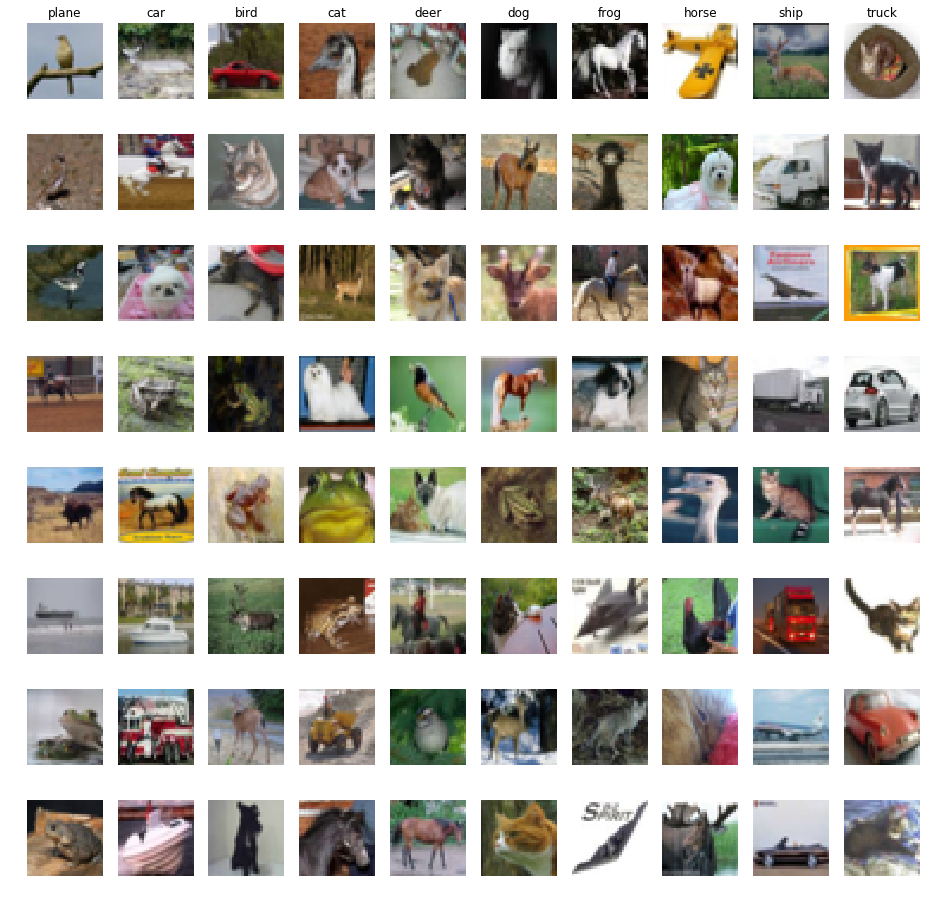

In [18]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

plt.figure(figsize=(16, 16))

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

$\color{blue}{\textit Your Answer:}$

They make sense for some classes like horses, cats and dogs because HOG features are used to determine edges in the images and animals like horses, cats and dogs have similar shape/edges that's why they can be misclassified as outcome HOG features. Also, we are using color histograms which is also makes easy to misclassify animals which have same colors. An example, there are some misclassification in deer and dogs data. There is brown colored dog classified as deer and also there is a brown colored deer classified as dog. We can give some examples for ship, plane and trucks. There are many misclassfied examples in that classes because HOG features. These classes have similar which most straight edges. That's why their HOG features are similar and that's the reason for the misclassification. 


## Neural Network on image features
Earlier in this assigment we saw that training a three-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 58% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [19]:
from comp411.classifiers.neural_net import ThreeLayerNet

np.random.seed(1)

input_dim = X_train_feats.shape[1]
num_classes = 10

best_net = None

import random

def params():
    
    learning_rate  = 10 ** np.random.uniform(-3, 0)
    regularization = 10 ** np.random.uniform(-8, -1)
    learning_decay = [0.95, 0.96, 0.97, 0.98, 0.99]
    batch_sizes    = [32, 64, 128, 256]
    hidden         = np.random.randint(50, 500)
    iterations     = [2000, 3000]
    
    return learning_rate, regularization, random.choice(learning_decay), hidden, random.choice(batch_sizes), random.choice(iterations)
        
################################################################################
# TODO: Train a three-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

accuracy_best  = 0

model_index = 0
model_total = 100

log = ""

for model_index in range(model_total):
    
    lr, reg, lr_dc, hidden, batch_size, iteration = params()
    
    net = ThreeLayerNet(input_dim, hidden, num_classes)

    loss_history = net.train(X_train_feats, y_train, 
                      X_val_feats, y_val,
                      num_iters=iteration, 
                      batch_size=batch_size,
                      learning_rate=lr,
                      learning_rate_decay=lr_dc,
                      reg=reg, 
                      verbose=False)

    accuracy_train = np.mean(net.predict(X_train_feats) == y_train)
    accuracy_val   = np.mean(net.predict(X_val_feats)   == y_val)

    log += f"[{model_index:02}/{model_total:02}]"
    log += f"[num_iter: {num_iter:03}]"
    log += f"[hidden: {hidden:03}]"
    log += f"[lr: {learning_rate:.4f}]"
    log += f"[reg: {reg:.4f}]"
    log += f"[batch: {batch_size:03}]"
    log += f"[acc_train: {accuracy_train:.4f}]"
    log += f"[acc_val: {accuracy_val:.4f}]"

    if accuracy_val > accuracy_best:
        best_net = net
        accuracy_best = accuracy_val
        log += "***"

    print(log)

    model_index += 1
    log = ""

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


[00/100][num_iter: 2000][hidden: 305][lr: 0.0067][reg: 0.0011][batch: 032][acc_train: 0.1003][acc_val: 0.0870]***
[01/100][num_iter: 2000][hidden: 358][lr: 0.0067][reg: 0.0000][batch: 256][acc_train: 0.8364][acc_val: 0.5660]***
[02/100][num_iter: 2000][hidden: 127][lr: 0.0067][reg: 0.0001][batch: 064][acc_train: 0.5512][acc_val: 0.4890]
[03/100][num_iter: 2000][hidden: 408][lr: 0.0067][reg: 0.0379][batch: 064][acc_train: 0.0998][acc_val: 0.1120]
[04/100][num_iter: 2000][hidden: 097][lr: 0.0067][reg: 0.0000][batch: 032][acc_train: 0.4331][acc_val: 0.4330]
[05/100][num_iter: 2000][hidden: 477][lr: 0.0067][reg: 0.0000][batch: 256][acc_train: 0.1004][acc_val: 0.0790]
[06/100][num_iter: 2000][hidden: 306][lr: 0.0067][reg: 0.0000][batch: 064][acc_train: 0.1003][acc_val: 0.0870]
[07/100][num_iter: 2000][hidden: 310][lr: 0.0067][reg: 0.0005][batch: 032][acc_train: 0.1004][acc_val: 0.0790]
[08/100][num_iter: 2000][hidden: 306][lr: 0.0067][reg: 0.0116][batch: 064][acc_train: 0.1000][acc_val: 0.0

[74/100][num_iter: 2000][hidden: 351][lr: 0.0067][reg: 0.0168][batch: 064][acc_train: 0.1004][acc_val: 0.0780]
[75/100][num_iter: 2000][hidden: 170][lr: 0.0067][reg: 0.0000][batch: 256][acc_train: 0.0999][acc_val: 0.1050]
[76/100][num_iter: 2000][hidden: 365][lr: 0.0067][reg: 0.0001][batch: 128][acc_train: 0.1003][acc_val: 0.0870]
[77/100][num_iter: 2000][hidden: 356][lr: 0.0067][reg: 0.0000][batch: 128][acc_train: 0.1004][acc_val: 0.0790]
[78/100][num_iter: 2000][hidden: 197][lr: 0.0067][reg: 0.0000][batch: 032][acc_train: 0.4915][acc_val: 0.4630]
[79/100][num_iter: 2000][hidden: 377][lr: 0.0067][reg: 0.0291][batch: 032][acc_train: 0.0998][acc_val: 0.1120]
[80/100][num_iter: 2000][hidden: 214][lr: 0.0067][reg: 0.0346][batch: 128][acc_train: 0.1004][acc_val: 0.0790]
[81/100][num_iter: 2000][hidden: 357][lr: 0.0067][reg: 0.0000][batch: 032][acc_train: 0.1000][acc_val: 0.0980]
[82/100][num_iter: 2000][hidden: 205][lr: 0.0067][reg: 0.0009][batch: 128][acc_train: 0.0998][acc_val: 0.1120]
[

In [17]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.559
